In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity']

coluna_ordinal_encoder=['median_income_cat']


In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler 

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust= Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])    

preprocessamento = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler),
    ],
)



In [7]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [10]:
param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree':[1, 2, 3],
    'regressor__reg__alpha': [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 25.0],
    
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   25.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit( X,y)   

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   25.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 20.0}

In [14]:
grid_search.best_score_

-50453.183947341866

In [15]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [16]:
coefs

,coeficiente
robust_scaler_poly__longitude,-0.878946
robust_scaler_poly__latitude,-0.782272
one_hot__ocean_proximity_INLAND,-0.491952
robust_scaler_poly__population_per_household,-0.329255
robust_scaler_poly__latitude^2,-0.287986
...,...
robust_scaler_poly__housing_median_age longitude^2,0.192099
robust_scaler_poly__latitude median_income population_per_household,0.211863
robust_scaler_poly__housing_median_age median_income,0.245686
robust_scaler_poly__bedrooms_per_room,0.315598


In [17]:
coefs[coefs['coeficiente']==0]

,coeficiente


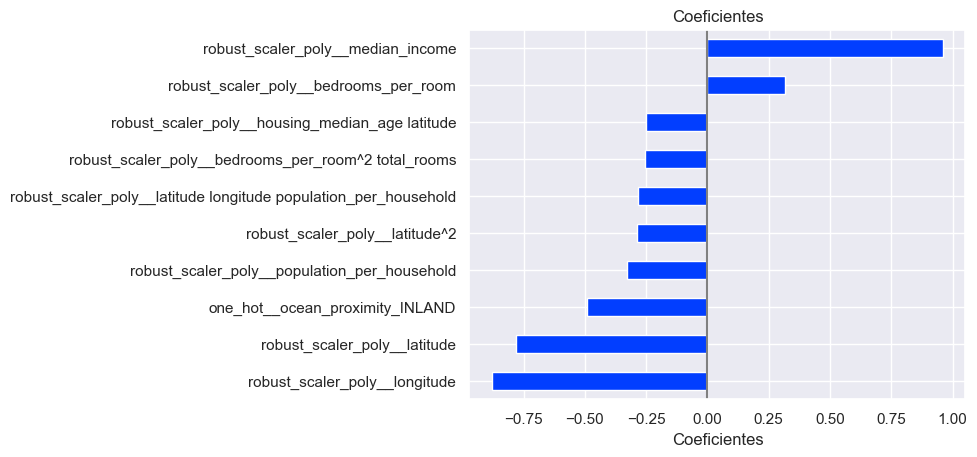

In [18]:
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.25,0.25)])

In [19]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
  'LinnearRegression_target':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'Ridge_grid_search':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.004606,0.006223,-0.000081,-77516.042766,-96239.705692,0.010829
1,DummyRegressor,0.003251,0.006225,-0.000146,-75787.787194,-95217.629397,0.009475
2,DummyRegressor,0.004505,0.005845,-0.001737,-76753.598961,-96253.253947,0.01035
3,DummyRegressor,0.006711,0.004118,-0.000101,-76837.804811,-95983.885799,0.010829
4,DummyRegressor,0.003344,0.006328,-0.000114,-76617.245449,-96182.764729,0.009672
5,LinnearRegression,0.054787,0.015687,0.682162,-39855.690996,-54254.958188,0.070474
6,LinnearRegression,0.045748,0.01862,0.66999,-40272.565467,-54695.230283,0.064368
7,LinnearRegression,0.047488,0.012486,0.649247,-42178.05929,-56955.988706,0.059975
8,LinnearRegression,0.045794,0.014921,0.669873,-40806.492497,-55146.318803,0.060715
9,LinnearRegression,0.046658,0.016606,0.669023,-40788.496497,-55331.35106,0.063264


In [20]:
df_resultados.groupby('model').mean().sort_values(by='test_neg_root_mean_squared_error')	


,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004483,0.005748,-0.000436,-76702.495836,-95975.447913,0.010231
LinnearRegression,0.048095,0.015664,0.668059,-40780.26095,-55276.769408,0.063759
LinnearRegression_target,0.056764,0.015667,0.678071,-38682.484783,-54433.166589,0.072431
Ridge_grid_search,0.213793,0.034636,0.723332,-35365.993435,-50453.176423,0.24843


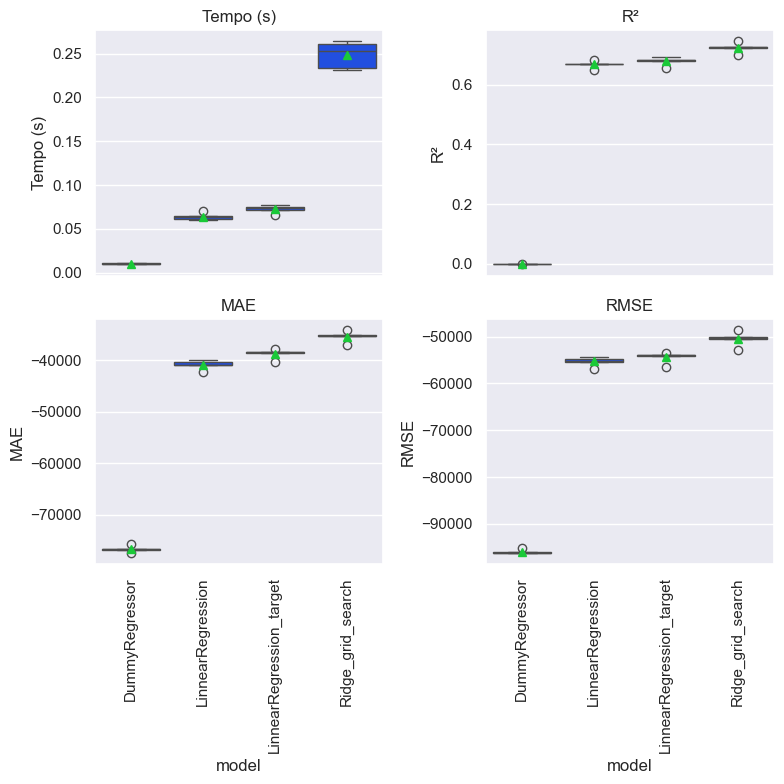

In [21]:
plot_comparar_metricas_modelos(df_resultados)

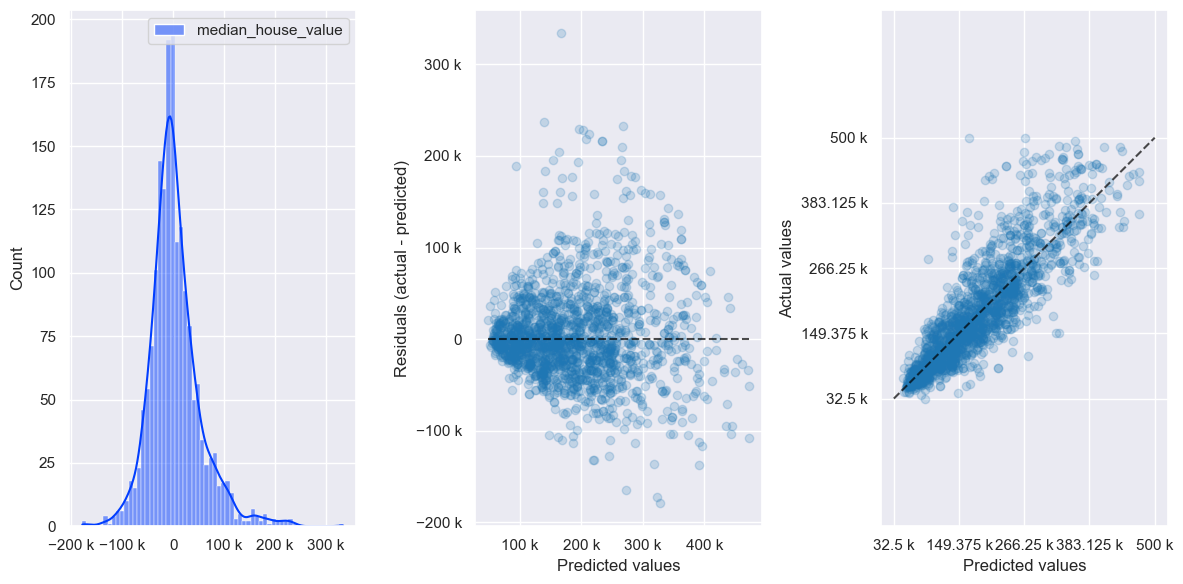

In [22]:
plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)


In [24]:
dump(grid_search.best_estimator_,MODELO_FINAL)

['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\regressao\\projeto\\modelos\\ridge_polyfeat_target_quantile.joblib']